### 1 Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 2 Data Loading

In [0]:
import pandas as pd
import numpy as np
from os.path import join
import glob
import os

# Chelsea's path
training_prefix='/content/drive/My Drive/Waymo_large_dataset/training/'
test_prefix='/content/drive/My Drive/Waymo_large_dataset/validation/'

def load_data_from_files_with_id(prefix):
    prefix = prefix.rstrip(os.sep)
    files = [f for f in glob.iglob(join(prefix, join('**', '*.csv')), recursive=True)]
    print("Loading data from {} files...".format(len(files)))

    df_list = []
    for i in range(len(files)):
      df = pd.read_csv(files[i], header = 0)
      idx = [i] * df.shape[0]
      df['id'] = idx
      df_list.append(df)
    
    return pd.concat(df_list)

def process_data(data):
  data = data.set_index('id')
  unique_ids = data.index.unique()
  return data, unique_ids

In [3]:
train = load_data_from_files_with_id(training_prefix)
test = load_data_from_files_with_id(test_prefix)

train, train_ids = process_data(train)
test, test_ids = process_data(test)

print(train.shape, test.shape)

Loading data from 798 files...
Loading data from 150 files...
(158361, 15) (29754, 15)


In [4]:
train.head()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az
id,,,,,,,,,,,,,,,
0,-10.954589,-2.117917,0.012756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.000000,0.000000,0.000000
0,-10.930109,-2.152400,-0.005913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-0.243569,0.343101,0.185750
0,-10.861781,-2.179386,-0.006538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-0.679845,0.268508,0.006225
0,-10.822652,-2.210152,-0.011221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.389326,0.306114,0.046590
0,-10.776157,-2.238142,-0.011096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.462608,0.278494,-0.001239


### 3 Lag feature generation

original features:
[vx, vy, vz, dx, dy, vfx, vfy, vfz, afx, afy, afz, num_v_labels]

New features:
[vx, vy, vz, dx, dy, vfx, vfy, vfz, afx, afy, afz, num_v_labels, vx_lag_1, vy_lag_1, vz_lag_1, vfx_lag_1, vfy_lag_1, vfz_lag_1]

In [0]:
def append_lag_features_for_single_id(single_data, feat_names, prev_n):
  data = single_data.copy()

  lag_feat = pd.DataFrame(single_data[feat_names].copy())

  for feat_name in feat_names:
    for i in range(1, prev_n + 1):
      data['{}_lag_{}'.format(feat_name, i)] = lag_feat[feat_name].shift(i)

  return data.dropna()

def append_lag_features(ori_data, uniq_ids, feat_names, prev_n):
  df_list = []
  for identifier in uniq_ids:
    single_data = ori_data.loc[identifier] #1
    processed_data = append_lag_features_for_single_id(single_data, feat_names, prev_n)
    df_list.append(processed_data)

  return pd.concat(df_list)

In [7]:
prev_n = 1
lag_feats = ['vx', 'vy', 'vz']

train_lagged = append_lag_features(train, train_ids, lag_feats, prev_n)
test_lagged = append_lag_features(test, test_ids, lag_feats, prev_n)

print(train_lagged.shape, test_lagged.shape)

(157563, 18) (29604, 18)


### 4 Model Training

In [0]:
import pandas as pd
import numpy as np
import xgboost
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [9]:
train = train_lagged
test = test_lagged

X = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels', 'vx_lag_1', 'vy_lag_1', 'vz_lag_1']]
Y_ax = train.loc[:,['ax']].values.ravel() # flatten to 1d array
Y_ay = train.loc[:,['ay']].values.ravel()

# y = Y_ax
X_train_ax, X_test_ax, y_train_ax, y_test_ax = train_test_split(X, Y_ax)
X_train_ay, X_test_ay, y_train_ay, y_test_ay = train_test_split(X, Y_ay)

X_test = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels', 'vx_lag_1', 'vy_lag_1', 'vz_lag_1']]
Y_test_ax = test.loc[:, ['ax']].values.ravel()
Y_test_ay = test.loc[:, ['ay']].values.ravel()

print("X_train_ax shape: {}, X_test_ax shape:{}".format(X_train_ax.shape, X_test_ax.shape))
print("y_train_ax shape: {}, y_test_ax shape:{}".format(y_train_ax.shape, y_test_ax.shape))

print("X_train_ay shape: {}, X_test_ay shape:{}".format(X_train_ay.shape, X_test_ay.shape))
print("y_train_ay shape: {}, y_test_ay shape:{}".format(y_train_ay.shape, y_test_ay.shape))


X_train_ax shape: (118172, 15), X_test_ax shape:(39391, 15)
y_train_ax shape: (118172,), y_test_ax shape:(39391,)
X_train_ay shape: (118172, 15), X_test_ay shape:(39391, 15)
y_train_ay shape: (118172,), y_test_ay shape:(39391,)


In [10]:
# GPU
model_XGB_ax_regressor = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=3,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85, 
        tree_method='gpu_hist', gpu_id=0)

# CPU
# model_XGB_ax_regressor = xgboost.XGBRegressor(
#         gamma=0.05,learning_rate=0.05, max_depth=3,
#         n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

model_XGB_ax_regressor.fit(X_train_ax, y_train_ax,
        eval_set=[(X_train_ax, y_train_ax), (X_test_ax, y_test_ax)],
        early_stopping_rounds=50, verbose=False)

[22:12:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05, gpu_id=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=0.85, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

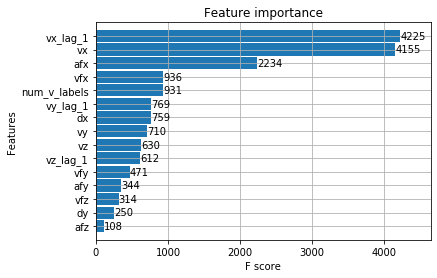

In [11]:
from xgboost import plot_importance

_ = plot_importance(model_XGB_ax_regressor, height=0.9)

In [14]:
model_name = "baseline"
y_label = "ax"

print("Predicting {} on test data..".format(model_name))
pred_Y = model_XGB_ax_regressor.predict(X_test)
print("MAE of {} for {} is {}".format(model_name, y_label, mean_absolute_error(pred_Y, Y_test_ax)))

Predicting baseline on test data..
MAE of baseline for ax is 0.27694125236600187


In [16]:
test['pred_ax'] = pred_Y

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az,vx_lag_1,vy_lag_1,vz_lag_1,pred_ax
id,,,,,,,,,,,,,,,,,,,
0,-1.540062,-0.089823,-0.004110,19.939327,1.802328,1.526405,0.077493,0.004109,0.617430,0.064007,-0.038098,27.0,-0.617498,-0.063932,0.038016,-1.602124,-0.096249,-0.000290,-0.768457
0,-1.526878,-0.108901,-0.017838,19.787335,1.781145,1.513234,0.096556,0.017846,0.131049,-0.189679,-0.136688,27.0,-0.131177,0.189820,0.136591,-1.540062,-0.089823,-0.004110,-0.180218
0,-1.481712,-0.096803,-0.014761,19.638062,1.751421,1.468087,0.084437,0.014786,0.449209,0.120582,0.030447,27.0,-0.449395,-0.120376,-0.030618,-1.526878,-0.108901,-0.017838,-0.505568
0,-1.419567,-0.085859,-0.021610,19.492854,1.733913,1.405953,0.073481,0.021631,0.618209,0.109016,-0.068107,27.0,-0.618327,-0.108886,0.068148,-1.481712,-0.096803,-0.014761,-0.644755
0,-1.399296,-0.110872,-0.017601,19.351571,1.713411,1.385692,0.098483,0.017623,0.201597,-0.248766,0.039882,28.0,-0.201692,0.248871,-0.039894,-1.419567,-0.085859,-0.021610,-0.228899


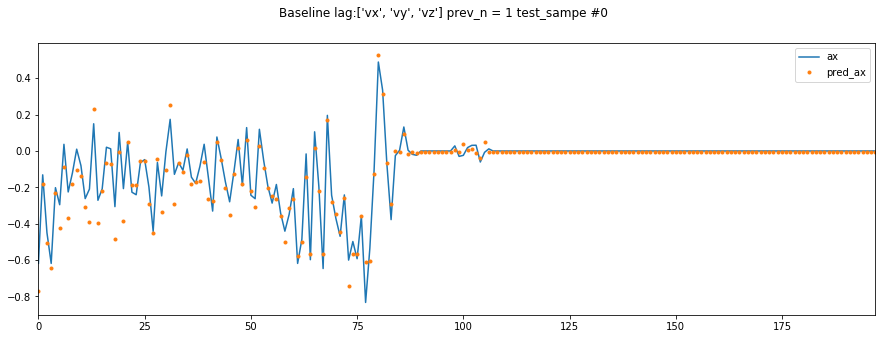

In [28]:
import matplotlib.pyplot as plt

sub_test = test.loc[0]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline lag:['vx', 'vy', 'vz'] prev_n = 1 test_sampe #0")